In [1]:
from pyvf.state_strategy import *
from pyvf.state_strategy.quadrant import *
from pyvf.state_strategy.fest import *
from pyvf.state_strategy.sors import *
from pyvf.state_strategy.staircase import *
from pyvf.resources.rotterdam2013 import *
from pyvf.plot import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import *
from functools import *
from itertools import *
from dataclasses import dataclass
import time

def grouper(iterable, n, *, incomplete='fill', fillvalue=None):
    "Collect data into non-overlapping fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, fillvalue='x') --> ABC DEF Gxx
    # grouper('ABCDEFG', 3, incomplete='strict') --> ABC DEF ValueError
    # grouper('ABCDEFG', 3, incomplete='ignore') --> ABC DEF
    args = [iter(iterable)] * n
    if incomplete == 'fill':
        return zip_longest(*args, fillvalue=fillvalue)
    if incomplete == 'strict':
        return zip(*args, strict=True)
    if incomplete == 'ignore':
        return zip(*args)
    else:
        raise ValueError('Expected fill, strict, or ignore')


In [2]:
# pd.plotting.scatter_matrix(pd.DataFrame(VF_THRESHOLD.clip(0, 33)).iloc[:, [0, 1, 2, 3, 36, 37, 38, 39]], alpha=0.02, hist_kwds={"bins": np.arange(-1, 40)})
# VF_THRESHOLD.mean(axis=0)
# plt.hist(VF_THRESHOLD[:, 23], bins=np.arange(-1, 40))

In [3]:
# scipy.stats.entropy([1, 1, 0], [1, 1, 1]), scipy.stats.entropy([1, 1, 0]), scipy.stats.entropy([1, 1, 1]), scipy.stats.entropy([1, 1, 0])-scipy.stats.entropy([1, 1, 1])

In [4]:
pretty_print_vf(VF_THRESHOLD[VF_THRESHOLD_SITES==20][3], apply_style=True, fmt="%.0f")

,-27.0,-21.0,-15.0,-9.0,-3.0,3.0,9.0,15.0,21.0,27.0
27.0,,,,,,,,,,
21.0,,,,-1,-1,-1,-1,,,
15.0,,,-1,-1,-1,-1,-1,-1,,
9.0,,-1,-1,-1,-1,-1,-1,-1,-1,
3.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,
-3.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,
-9.0,,-1,-1,-1,-1,-1,-1,-1,-1,
-15.0,,,-1,-1,-1,-1,-1,-1,,
-21.0,,,,-1,-1,-1,-1,,,
-27.0,,,,,,,,,,


In [5]:
# def fun():
method = "sorszest"
parameter = None
if method:
    tic = time.perf_counter()

    results = []


    for true_site_index in np.unique(VF_THRESHOLD_SITES):
        true_threshold = np.median(VF_THRESHOLD[VF_THRESHOLD_SITES == true_site_index, :], axis=0)
        print(true_site_index, end=".")
        # display(pretty_print_vf(true_threshold, apply_style=True, fmt="%.0f"))

        mask = VF_THRESHOLD_SITES != true_site_index
        eyes = VF_THRESHOLD_SITES[mask]
        database = VF_THRESHOLD[mask, :]




        # Training
        counts = pd.value_counts(eyes, sort=False)
        weights = 1.0 / counts / len(counts)
        weights = weights[eyes].values

        if True: # method == "quadrantzest" or method == "sorszest":

            bins = np.array([-2, 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34])
            bin_mid = np.array([-1,  1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33])
            density_p0 = np.zeros((database.shape[1], len(bin_mid)), dtype=np.float64)
            for i in range(database.shape[1]):
                thresholds = database[:, i].clip(-2, 34)
                density, _ = np.histogram(thresholds, bins=bins, weights=weights, density=False)
                # density.sum() == 2
                density_p0[i, :] = density

        if method == "quadrantzest":
            state = QuadrantFieldState(
                        nodes=[
                            # StateNode(instance=StaircasePointState(
                            StateNode(instance=ZestPointState(
                                point=Point(index=pt[LOC], x=pt[XOD], y=pt[YOD]),
                                x=bin_mid,
                                q0=q0,
                                terminate_std=1.5
                                # pretest=bin_mid[bin_mid > 10][q0[bin_mid > 10].argmax()]
                            )) for q0, pt in zip(density_p0, PATTERN_P24D2)
                        ],
                        quadrant_map=get_quadrant_map("P24D2")
                    )

        elif method == "quadrantstair":
            state = QuadrantFieldState(
                        nodes=[
                            StateNode(instance=StaircasePointState(
                            # StateNode(instance=ZestPointState(
                                point=Point(index=pt[LOC], x=pt[XOD], y=pt[YOD]),
                                # x=bin_mid,
                                # q0=q0,
                                # terminate_std=1.5
                                pretest=bin_mid[bin_mid > 10][q0[bin_mid > 10].argmax()]
                            )) for q0, pt in zip(density_p0, PATTERN_P24D2)
                        ],
                        quadrant_map=get_quadrant_map("P24D2")
                    )

        elif method == "modestair":
            state = QuadrantFieldState(
                        nodes=[
                            StateNode(instance=StaircasePointState(
                            # StateNode(instance=ZestPointState(
                                point=Point(index=pt[LOC], x=pt[XOD], y=pt[YOD]),
                                # x=bin_mid,
                                # q0=q0,
                                # terminate_std=1.5
                                pretest=bin_mid[bin_mid > 10][q0[bin_mid > 10].argmax()]
                            )) for q0, pt in zip(density_p0, PATTERN_P24D2)
                        ],
                        quadrant_map=get_flat_map("P24D2")
                    )

        elif method == "meanstair":
            state = QuadrantFieldState(
                        nodes=[
                            StateNode(instance=StaircasePointState(
                            # StateNode(instance=ZestPointState(
                                point=Point(index=pt[LOC], x=pt[XOD], y=pt[YOD]),
                                # x=bin_mid,
                                # q0=q0,
                                # terminate_std=1.5
                                pretest=bin_mid @ q0
                            )) for q0, pt in zip(density_p0, PATTERN_P24D2)
                        ],
                        quadrant_map=get_flat_map("P24D2")
                    )

        elif method == "feststair":

            state = FestFieldState(
                nodes=[
                    StateNode(instance=StaircasePointState(
                    # StateNode(instance=ZestPointState(
                        point=Point(index=pt[LOC], x=pt[XOD], y=pt[YOD]),
                        # x=bin_mid,
                        # q0=q0,
                        # terminate_std=1.5
                        pretest=30 # Any number
                    )) for pt in PATTERN_P24D2
                ],
                database=database.clip(-1, 33),
                database_p=weights,
                seeding_terminate_entropy=scipy.stats.entropy(weights) * parameter
            )

        elif method == "sorszest":
            @dataclass
            class LinearPredictor:
                weight: np.ndarray

                def predict(self, X):
                    return self.weight @ X

            Omega_star_S, D_star = train_sors(database)
            batches = tuple(tuple(i for i in l if i is not None) for l in grouper(Omega_star_S, 4))
            state = GenericSorsFieldState(
                        nodes=[
                            StateNode(instance=ZestPointState(
                                point=Point(index=pt[LOC], x=pt[XOD], y=pt[YOD]),
                                x=bin_mid,
                                q0=q0,
                                terminate_std=1.5
                            )) for q0, pt in zip(density_p0, PATTERN_P24D2)
                        ],
                        batches=batches,
                        models=[LinearPredictor(w) for w in D_star]
                    )
        else:
            raise NotImplementedError()
            
        field_state_node = StateNode(instance=state)

        trial = field_state_node.instance.next_trial
        i = 0
        while trial is not None:
            seen = np.random.default_rng().uniform() < pos_ramp(trial.threshold, true_threshold[trial.point.index], yl=0.95, yr=0.05, width=4) # trial.threshold <= true_threshold[trial.point.index] + np.random.default_rng().normal(0, 0.01)
            trial = evolve(trial, seen=seen)
            field_state_node = field_state_node.add_trial(trial)
            i += 1
            # if i > 120:
            #     break
            # print(i, trial, np.around(field_state_node.instance.estimate))
            # print(field_state_node.instance.database_p)
            # print(i, field_state_node.instance.seeding_terminated, np.around(field_state_node.instance.estimate, 1).tolist())
            trial = field_state_node.instance.next_trial

        # print(len(field_state_node.previous_edges))
        # print(np.around(field_state_node.instance.estimate))
        # print(true_threshold)
        # print(np.clip(field_state_node.instance.estimate, 0, 33)-np.clip(true_threshold, 0, 33))


        estimates = np.array([s.instance.estimate for s in field_state_node.previous_states])
        error = estimates.clip(0, 33) - true_threshold.clip(0, 33)
        rmse = (error ** 2).mean(axis=1) ** 0.5
        mae = np.abs(error).mean(axis=1)
        
        results.append({
            "true_site_index": true_site_index,
            "strategy": type(field_state_node.instance).__name__,
            "num_trials": len(field_state_node.previous_edges),
            "rmse": np.array(rmse, dtype=np.float32),
            "mae": np.array(mae, dtype=np.float32),
            "vf": np.array(field_state_node.instance.estimate, dtype=np.float32)
        })

    toc = time.perf_counter()
    print(f"Duration: {toc - tic} seconds, {(toc - tic)/len(results)} per result")
# from line_profiler.line_profiler import LineProfiler

# lp = LineProfiler()
# lp(fun)()
# lp.print_stats()


1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.277.

In [49]:
df = pd.DataFrame(results)
# df.strategy = pd.Categorical(df.strategy)
df.to_pickle(rf"output_reliable_5\performance_{method}{('_'+str(parameter)) if parameter is not None else ''}.pickle.zip")
df.dtypes

true_site_index     int32
strategy           object
num_trials          int64
rmse               object
mae                object
vf                 object
dtype: object

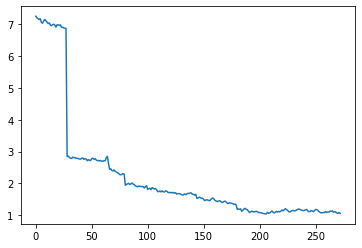

In [6]:
plt.plot(mae)

In [51]:
# sorszest = pd.read_pickle(r"output_perfect\performance_sorszest.pickle.zip")
feststair10 = pd.read_pickle(r"output_reliable_5\performance_feststair_1.0.pickle.zip")
feststair08 = pd.read_pickle(r"output_reliable_5\performance_feststair_0.8.pickle.zip")
feststair06 = pd.read_pickle(r"output_reliable_5\performance_feststair_0.6.pickle.zip")
feststair04 = pd.read_pickle(r"output_reliable_5\performance_feststair_0.4.pickle.zip")
feststair02 = pd.read_pickle(r"output_reliable_5\performance_feststair_0.2.pickle.zip")
quadrantzest = pd.read_pickle(r"output_reliable_5\performance_quadrantzest.pickle.zip")
quadrantstair = pd.read_pickle(r"output_reliable_5\performance_quadrantstair.pickle.zip")
modestair = pd.read_pickle(r"output_reliable_5\performance_modestair.pickle.zip")
meanstair = pd.read_pickle(r"output_reliable_5\performance_meanstair.pickle.zip")

data = []
for strategy, df in (("FEST-Stair-0.2", feststair02), ("FEST-Stair-0.4", feststair04), ("FEST-Stair-0.6", feststair06), ("FEST-Stair-0.8", feststair08), ("Mean-Stair", meanstair),
                    ("Quadrant-Stair", quadrantstair), ("Mode-Stair", modestair) #  ("SORS-ZEST", sorszest), ("Quadrant-ZEST", quadrantzest)
                     ):
    print("X", end="")
    for _, row in df.iterrows():
        # print(".", end="")
        for i, (r, m) in enumerate(zip(row.rmse, row.mae)):
            data.append({
                "site": row.true_site_index,
                "strategy": strategy,
                "num_trials": row.num_trials,
                "trial": i,
                "rmse": r,
                "mae": m,
                "terminated": False
            })
        assert i == row.num_trials
        # Append data up to 500 trials
        for i in range(row.num_trials + 1, 500):
            data.append({
                "site": row.true_site_index,
                "strategy": strategy,
                "num_trials": row.num_trials,
                "trial": i,
                "rmse": r,
                "mae": m,
                "terminated": False
            })
    print()


X
X
X
X
X
X
X


In [52]:
# VF_THRESHOLD_INFO.groupby("STUDY_SITE_ID").median().reset_index()
# pd.cut(VF_THRESHOLD_INFO.groupby("STUDY_SITE_ID").median().reset_index().MD, np.arange(-36, +7, 6)).value_counts(sort=False)

In [53]:
df = pd.DataFrame(data)
df = df.merge(VF_THRESHOLD_INFO.groupby("STUDY_SITE_ID").median().reset_index(), how="left", left_on="site", right_on="STUDY_SITE_ID")
df

,site,strategy,num_trials,trial,rmse,mae,terminated,STUDY_SITE_ID,FIELD_ID,STUDY_ID,MD,AGE,IOP
0,1,FEST-Stair-0.2,258,0,9.212764,7.766005,False,1,2398.0,1.0,-10.16,20768.0,11.0
1,1,FEST-Stair-0.2,258,1,9.358656,6.585294,False,1,2398.0,1.0,-10.16,20768.0,11.0
2,1,FEST-Stair-0.2,258,2,8.658092,7.430040,False,1,2398.0,1.0,-10.16,20768.0,11.0
3,1,FEST-Stair-0.2,258,3,9.520685,8.216928,False,1,2398.0,1.0,-10.16,20768.0,11.0
4,1,FEST-Stair-0.2,258,4,8.470444,6.966876,False,1,2398.0,1.0,-10.16,20768.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
972995,278,Mode-Stair,268,495,2.419060,1.518519,False,278,3086.0,139.0,-6.60,29069.0,20.0
972996,278,Mode-Stair,268,496,2.419060,1.518519,False,278,3086.0,139.0,-6.60,29069.0,20.0
972997,278,Mode-Stair,268,497,2.419060,1.518519,False,278,3086.0,139.0,-6.60,29069.0,20.0
972998,278,Mode-Stair,268,498,2.419060,1.518519,False,278,3086.0,139.0,-6.60,29069.0,20.0


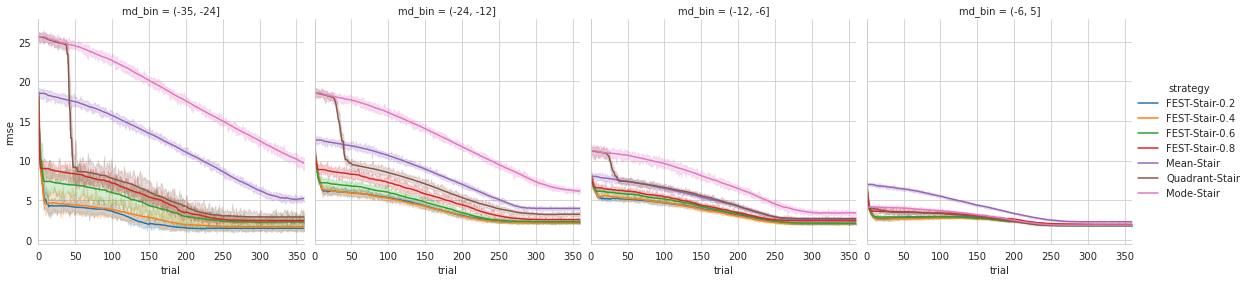

In [54]:
with sns.axes_style("whitegrid"):
    df["md_bin"] = pd.cut(df.MD, [-35, -24, -12, -6, +5])
    # print(df.md_bin.value_counts(sort=False))
    fg = sns.relplot(data=df, x="trial", y="rmse", hue="strategy", ci=95, n_boot=10, col="md_bin", kind="line", height=4)
    for ax in fg.axes.ravel():
        ax.set(xlim=[0, 360])



In [55]:
fg.fig.savefig("output.svg")

(array([ 1.,  0.,  0.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  4.,  2.,  5.,
         5.,  4.,  5.,  9.,  3., 10., 19., 35., 16., 18.,  7., 11.,  7.,
        12.,  1.,  7.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19]),
 <BarContainer object of 39 artists>)

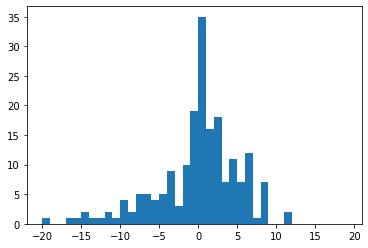

In [96]:
bins = np.array([-2, 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34])
bin_mid = np.array([-1,  1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33])
retest_values = defaultdict(lambda : [])

def get_index(x, bins):
    # assume bins is sorted
    for i, v in enumerate(bins):
        if x <= v:
            return i - 1

loc = 23
for site, d in pd.DataFrame(VF_THRESHOLD).groupby(VF_THRESHOLD_SITES):
    # print(site)
    # print(d.values[:, loc])
    med = np.median(d.values[:, loc])
    bin_value = bin_mid[get_index(
        med, 
        bins=bins)]
    # print(bin_value, np.median(d.values[:, loc]))
    retest_values[bin_value].extend((d.values[:, loc]-med).tolist())
    # break

plt.hist(retest_values[21], bins=np.arange(-20, +20, 1))